# TO DO

1. Pick a dataset
2. Download The dataset
3. Import the dataset using Pytorch
4. Explore the dataset
5. Prepare the dataset for training
6. Train the Dataset 
7. Predict

## Download The Dataset

Using OpenDataset and Donwload the dataset from https://www.kaggle.com/alxmamaev/flowers-recognition

In [1]:
#!pip install opendatasets --upgrade --quiet

In [2]:
#import opendatasets as od

In [3]:
#dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [4]:
#od.download(dataset_url)

In [5]:
data_dir = '../input/flowers-recognition/flowers/flowers'

In [6]:
import os
for file in os.listdir(data_dir):
    print(data_dir+file)

../input/flowers-recognition/flowers/flowersdandelion
../input/flowers-recognition/flowers/flowersdaisy
../input/flowers-recognition/flowers/flowerssunflower
../input/flowers-recognition/flowers/flowerstulip
../input/flowers-recognition/flowers/flowersrose


In [7]:
os.listdir(data_dir)

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

In [8]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

dandelion : 1055
daisy : 769
sunflower : 734
tulip : 984
rose : 784


### Imoprt the datasets into Pytorch

Use the `ImageFloder` class from `torchvision`

In [9]:
from torchvision.datasets import ImageFolder

In [10]:
dataset = ImageFolder(data_dir)

In [11]:
len(dataset)

4323

In [12]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F6484E6B990>, 0)

In [13]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

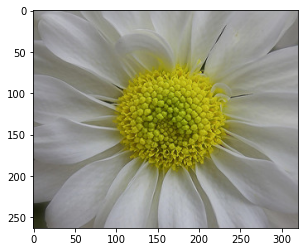

In [15]:
img, label = dataset[0]
plt.imshow(img);

In [16]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

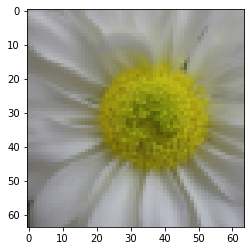

In [17]:
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0));

In [18]:
val_pct = 0.1 # validation %
val_size = int(val_pct * len(dataset))

train_size = len(dataset) - val_size

train_size, val_size

(3891, 432)

In [19]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3891, 432)

In [20]:

from torch.utils.data import DataLoader

batch_size = 64

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

val_dl = DataLoader(valid_ds, 
                    batch_size*2, 
                    num_workers=4, 
                    pin_memory=True)

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

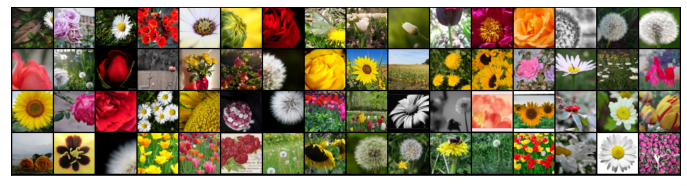

In [22]:
show_batch(train_dl)

## GPU Utilities

In [23]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
torch.cuda.is_available()

True

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
img, label = dataset[0]

In [27]:
img.device

device(type='cpu')

In [28]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [29]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

### Model and Training Utiliies

In [30]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
      '''calculate loss for a batch of training data'''

      images, labels = batch 
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      return loss
    
    def validation_step(self, batch):
      '''calculate loss for a batch of validation data'''
      images, labels = batch 
      out = self(images)                    # Generate predictions
      loss = F.cross_entropy(out, labels)   # Calculate loss
      acc = accuracy(out, labels)           # Calculate accuracy
      return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
  ''' Evaluates the model's performance on the validation set '''
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model 

In [32]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) #  128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128),  # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) #  128 x 512 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True) 
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [33]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [34]:
model.conv1[0].weight

Parameter containing:
tensor([[[[ 0.1424, -0.1116,  0.1632],
          [-0.1482, -0.1754, -0.1808],
          [-0.1703, -0.0351,  0.0373]],

         [[-0.1165,  0.0611,  0.1444],
          [-0.0536,  0.0945,  0.0053],
          [ 0.1460,  0.0204, -0.0509]],

         [[ 0.1011, -0.0740, -0.0105],
          [-0.1525,  0.1103,  0.1404],
          [ 0.1183, -0.0997,  0.0652]]],


        [[[ 0.1878, -0.0875, -0.1113],
          [-0.1478,  0.0429,  0.0991],
          [-0.0103, -0.0397, -0.1455]],

         [[-0.0375, -0.0263,  0.0226],
          [ 0.1817, -0.0664, -0.0728],
          [ 0.0228, -0.0441, -0.1675]],

         [[ 0.0042,  0.1254, -0.1868],
          [ 0.1076, -0.1447,  0.0048],
          [ 0.1162,  0.0330,  0.0269]]],


        [[[-0.1620,  0.1625,  0.0530],
          [-0.0086, -0.0856,  0.1202],
          [ 0.0187,  0.1661,  0.1855]],

         [[-0.1508, -0.1543, -0.1145],
          [-0.1170, -0.0570, -0.1142],
          [-0.0584,  0.0717,  0.0673]],

         [[ 0.0855, -0

In [35]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model

In [36]:
torch.cuda.empty_cache()
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device',images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  print(preds)
  
  break

images.shape torch.Size([64, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([64, 5])
tensor([[ 3.3745e+00, -6.1324e-01, -9.0776e-01,  4.0842e+00,  5.3797e-01],
        [ 6.8361e-01,  1.7195e+00, -2.0019e+00,  6.6239e+00, -9.8068e-02],
        [ 5.7231e-01, -3.3822e-01, -4.4455e-01,  3.3100e+00,  6.0523e-01],
        [ 2.7606e+00, -1.2091e+00,  2.0692e+00,  5.3652e+00,  5.0869e-01],
        [ 3.6413e+00, -3.2868e+00,  3.3097e+00,  4.4605e+00, -7.1627e-01],
        [-3.1216e-01,  4.8803e-01, -2.5002e+00,  6.1349e+00,  1.4669e+00],
        [-5.3000e-01, -2.2729e+00, -2.1910e+00,  2.5684e+00,  1.5387e+00],
        [-3.0654e-01,  1.5858e-01,  2.8632e+00,  6.3713e+00,  1.2051e+00],
        [ 1.7953e+00, -1.1281e+00,  5.9557e-01,  3.7695e+00,  9.6289e-01],
        [ 3.6226e+00, -1.6052e+00,  7.6359e-01,  3.7111e+00,  1.9966e+00],
        [ 1.8869e+00,  6.6274e-01,  1.0011e+00,  6.1814e+00, -5.1232e-01],
        [ 9.3166e-01, -1.5666e-01,  1.5340e-01,  2.8808e+00, -4.2262e-01],
      

## Training

In [37]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6166737079620361, 'val_acc': 0.1575520783662796}]

In [38]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.3943, val_loss: 0.9434, val_acc: 0.6647
Epoch [1], train_loss: 0.9722, val_loss: 0.9506, val_acc: 0.6367
Epoch [2], train_loss: 0.8597, val_loss: 0.9616, val_acc: 0.6895
Epoch [3], train_loss: 0.7774, val_loss: 0.7908, val_acc: 0.7109
Epoch [4], train_loss: 0.7263, val_loss: 1.5786, val_acc: 0.5417


In [39]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.5635, val_loss: 0.5283, val_acc: 0.8079
Epoch [1], train_loss: 0.4968, val_loss: 0.5022, val_acc: 0.8288
Epoch [2], train_loss: 0.4866, val_loss: 0.5595, val_acc: 0.7975
Epoch [3], train_loss: 0.4431, val_loss: 0.5143, val_acc: 0.8229
Epoch [4], train_loss: 0.4200, val_loss: 0.4853, val_acc: 0.8314


In [40]:
history += fit(5, 0.00001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3638, val_loss: 0.4622, val_acc: 0.8379
Epoch [1], train_loss: 0.3581, val_loss: 0.4597, val_acc: 0.8294
Epoch [2], train_loss: 0.3462, val_loss: 0.4542, val_acc: 0.8275
Epoch [3], train_loss: 0.3490, val_loss: 0.4712, val_acc: 0.8405
Epoch [4], train_loss: 0.3407, val_loss: 0.4692, val_acc: 0.8346


In [41]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.SGD)

Epoch [0], train_loss: 0.3316, val_loss: 0.4450, val_acc: 0.8424
Epoch [1], train_loss: 0.3347, val_loss: 0.4705, val_acc: 0.8197
Epoch [2], train_loss: 0.3365, val_loss: 0.4358, val_acc: 0.8268
Epoch [3], train_loss: 0.3230, val_loss: 0.4661, val_acc: 0.8294
Epoch [4], train_loss: 0.3365, val_loss: 0.4486, val_acc: 0.8262


In [42]:
history += fit(5, 0.00001, model, train_dl, valid_dl, torch.optim.SGD)

Epoch [0], train_loss: 0.3298, val_loss: 0.4588, val_acc: 0.8366
Epoch [1], train_loss: 0.3374, val_loss: 0.4585, val_acc: 0.8405
Epoch [2], train_loss: 0.3212, val_loss: 0.4541, val_acc: 0.8418
Epoch [3], train_loss: 0.3328, val_loss: 0.4689, val_acc: 0.8249
Epoch [4], train_loss: 0.3270, val_loss: 0.4385, val_acc: 0.8320


In [43]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

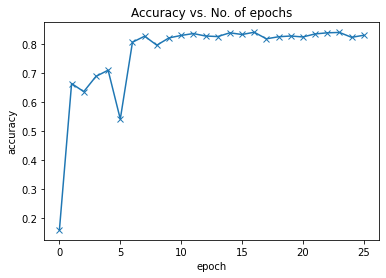

In [44]:
plot_accuracies(history)

In [45]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

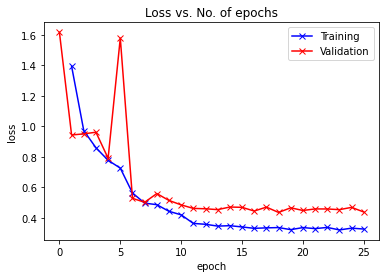

In [46]:
plot_losses(history)

### Test with indivisual Images

In [47]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [48]:
def show_image_prediction(img, label):
  plt.imshow(img.permute((1,2,0)))
  pred = predict_image(img, model, dataset.classes)
  print('Target:', dataset.classes[label])
  print('Prediction:', pred)

Target: sunflower
Prediction: sunflower


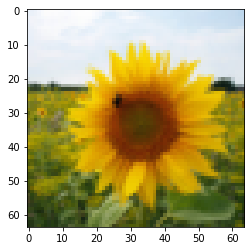

In [49]:
show_image_prediction(*valid_ds[100])

Target: dandelion
Prediction: dandelion


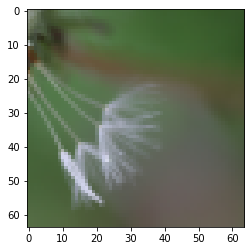

In [50]:
show_image_prediction(*valid_ds[352])

Target: dandelion
Prediction: dandelion


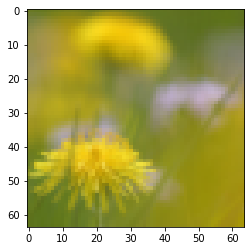

In [51]:
show_image_prediction(*valid_ds[265])

Target: tulip
Prediction: tulip


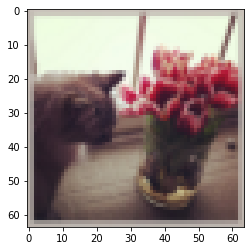

In [52]:
show_image_prediction(*valid_ds[402])

Target: tulip
Prediction: tulip


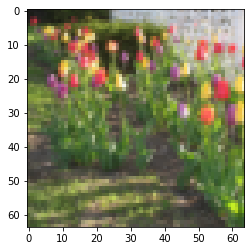

In [53]:
show_image_prediction(*valid_ds[4])

In [54]:
torch.save(model.state_dict(), 'flower-resnet9.pth')